# Sparkify Project

In [1]:
import os
from pyspark.sql import SparkSession

In [2]:
# Starting a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

In [3]:
from pyspark import SparkContext as sc
from pyspark import SparkConf

In [4]:
# libraries
import pandas as pd
import numpy as np
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.ml.feature import Normalizer, StandardScaler, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, LogisticRegression, MultilayerPerceptronClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.tuning import CrossValidatorModel as mlm
import re
import datetime
from pyspark.sql import Window
from matplotlib import pyplot as plt
import re
from pyspark.sql import functions as sF
from pyspark.sql import types as sT
from functools import reduce

## Data Cleaning
Handling invalid or missing data like rows without userids or sessionids. 

In [5]:
#data_path = 's3n://udacity-dsnd/sparkify/sparkify_event_data.json'
data_path = 'mini_sparkify_event_data.json'
df = spark.read.json(data_path)
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
dfp = df.toPandas()
dfp.head(2)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9


In [7]:
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int64
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           286500 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 39.3+ MB


In [8]:
dfp.level.unique(), dfp.level.isnull().sum()

(array(['paid', 'free'], dtype=object), 0)

In [9]:
dfp.method.unique(), dfp.method.isnull().sum()

(array(['PUT', 'GET'], dtype=object), 0)

In [10]:
dfp.page.unique(), dfp.page.isnull().sum()

(array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
        'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Login',
        'Upgrade', 'Add Friend', 'About', 'Settings', 'Submit Upgrade',
        'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
        'Cancellation Confirmation', 'Register', 'Submit Registration'], dtype=object),
 0)

In [11]:
dfp.status.unique(), dfp.status.isnull().sum()

(array([200, 307, 404]), 0)

In [12]:
dfp.gender.unique(), dfp.gender.isnull().sum()

(array(['M', 'F', None], dtype=object), 8346)

In [13]:
dfp.auth.unique(), dfp.auth.isnull().sum()

(array(['Logged In', 'Logged Out', 'Cancelled', 'Guest'], dtype=object), 0)

In [14]:
df.filter(df.userId == '').count(), dfp.userId.isnull().sum()

(8346, 0)

In [15]:
# Removing the rows with missing userId
df = df.filter(df.userId != '')
df.filter(df.userId == '').count()

0

In [16]:
df[df.sessionId == ''].count()

0

In [17]:
dfp = df.toPandas()

In [18]:
dfp.level.unique(), dfp.method.unique(), dfp.page.unique(), dfp.status.unique(), dfp.gender.unique(), dfp.auth.unique()

(array(['paid', 'free'], dtype=object),
 array(['PUT', 'GET'], dtype=object),
 array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
        'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Upgrade',
        'Add Friend', 'Settings', 'Submit Upgrade', 'About',
        'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
        'Cancellation Confirmation'], dtype=object),
 array([200, 307, 404]),
 array(['M', 'F'], dtype=object),
 array(['Logged In', 'Cancelled'], dtype=object))

## Exploratory Data Analysis (EDA)

In [19]:
df.select("userId").dropDuplicates().count()

225

In [20]:
df.select("page").dropDuplicates().count()

19

In [21]:
df.select("sessionId").dropDuplicates().count()

2312

In [22]:
# Defining Churn: user who cancelled the subscription
udf_cancelation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn", udf_cancelation_event("page"))
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn("churn", Fsum("churn").over(windowval))

In [23]:
dfp = df.toPandas()

In [24]:
dfp[(dfp['userId'] == '29') & (dfp['page'] == 'Cancellation Confirmation')]

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
31620,None,Cancelled,Kaleb,M,49,Thompson,NaN,paid,"Los Angeles-Long Beach-Anaheim, CA",GET,Cancellation Confirmation,1536988041000,1864,None,200,1542181031000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",29,1


In [25]:
dfp.sample(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
259924,Doves,Logged In,Alyssa,F,24,Johnston,311.48363,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1532634173000,584,Kingdom Of Rust,200,1539201521000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,66,0
68513,Portugal. The Man,Logged In,Noah,M,18,Whitehead,179.30404,free,"New Haven-Milford, CT",PUT,NextSong,1535361448000,300,People Say,200,1542378779000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5...",300006,0
82647,None,Logged In,Daelin,M,73,Turner,NaN,free,"New York-Newark-Jersey City, NY-NJ-PA",PUT,Thumbs Up,1538227408000,841,None,307,1539549155000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",126,0
252155,Holly Brook,Logged In,Sophia,F,90,Perry,236.40771,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1533885783000,910,Wanted (Album Version),200,1539736194000,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) G...,12,1
209324,Shunza,Logged In,Destiny,F,256,Herring,250.93179,paid,"Miami-Fort Lauderdale-West Palm Beach, FL",PUT,NextSong,1536844410000,1116,Nan Ni Wan,200,1540213112000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",20,0


In [26]:
dfp.sample(2)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
21930,Des'ree,Logged In,Samuel,M,459,Wood,246.30812,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,1537865819000,1305,You Gotta Be,200,1540675805000,"""Mozilla/5.0 (iPad; CPU OS 7_1_1 like Mac OS X...",138,0
196620,None,Logged In,Molly,F,27,Harrison,NaN,free,"Virginia Beach-Norfolk-Newport News, VA-NC",GET,Settings,1534255113000,306,None,200,1538668765000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",143,1


In [27]:
dfp.drop_duplicates(subset='userId').groupby(['churn'])['userId'].count()

churn
0    173
1     52
Name: userId, dtype: int64

In [28]:
df.dropDuplicates(['userId']).groupby(['churn']).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [29]:
df.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    1|     M|   32|
|    1|     F|   20|
|    0|     M|   89|
+-----+------+-----+



In [30]:
df.dropDuplicates(['userId', 'level']).groupby(['churn', 'level']).count().show()

+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|    1| paid|   36|
|    1| free|   46|
|    0| free|  149|
|    0| paid|  129|
+-----+-----+-----+



In [31]:
def preliminaryPlot(subset, group, labels, x_title="Subscription status",y_title="Number of users"):
    ax = dfp.drop_duplicates(subset=subset).groupby(
                                group)['userId'].count().plot(
                                kind='bar', figsize=(8,5), 
                                title='Number of unique users per category');
    ax.set_xlabel(x_title);
    ax.set_xticklabels(labels, rotation=0)
    ax.set_ylabel(y_title);

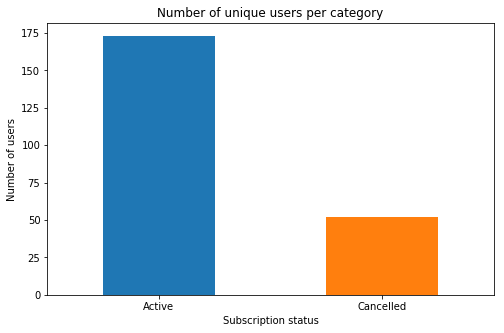

In [32]:
preliminaryPlot(['userId'], ['churn'], ['Active', 'Cancelled'])


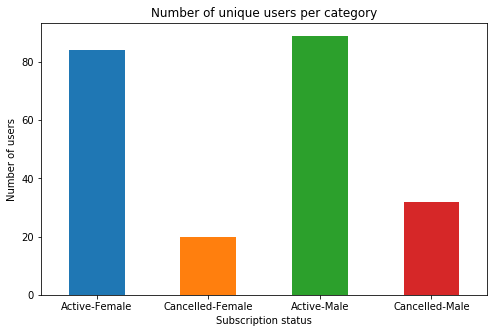

In [33]:
preliminaryPlot(['userId', 'gender'], ['gender', 'churn'], ['Active-Female', 'Cancelled-Female', 'Active-Male', 'Cancelled-Male'])

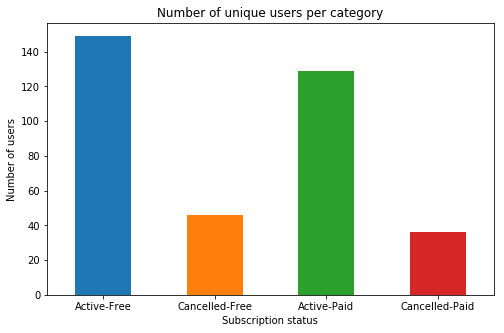

In [34]:
preliminaryPlot(['userId', 'level'],['level', 'churn'],['Active-Free', 'Cancelled-Free', 'Active-Paid', 'Cancelled-Paid'])

In [35]:
cancelledUsers = dfp[dfp.churn == 1].groupby(['page'])['userId'].count().drop('NextSong')
cancelledUsers = cancelledUsers /cancelledUsers.sum()*100

activeUsers = dfp[dfp.churn == 0].groupby(['page'])['userId'].count().drop('NextSong')
activeUsers = activeUsers /activeUsers.sum()*100

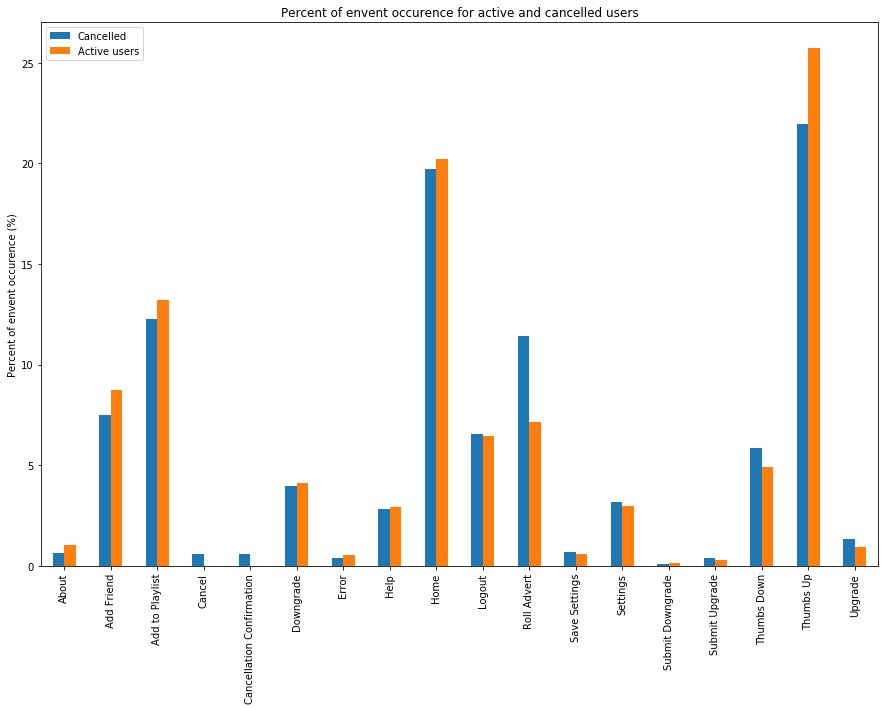

In [36]:
users_df = pd.DataFrame({'Cancelled': cancelledUsers,'Active users':activeUsers})
ax = users_df.plot(kind='bar', figsize=(15,10));
ax.set_ylabel('Percent of envent occurence (%)')
ax.set_title('Percent of envent occurence for active and cancelled users');

In [37]:
dfp = df.toPandas()
dfp.sample(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
202206,Old Crow Medicine Show,Logged In,Micah,M,128,Long,323.97016,paid,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,2259,Methamphetamine,200,1543264581000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
137959,None,Logged In,Isaiah,M,3,Gomez,NaN,paid,"London, KY",PUT,Add to Playlist,1537897424000,208,None,200,1540346206000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:31....,200024,1
179060,None,Logged In,Angel,M,45,Jacobs,NaN,free,"Spokane-Spokane Valley, WA",GET,Roll Advert,1536257455000,71,None,200,1538949847000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:31....,100019,1
91308,The Prodigy,Logged In,Lucero,F,655,Reed,225.09669,paid,"Louisville/Jefferson County, KY-IN",PUT,NextSong,1536642109000,1483,Firestarter,200,1541200426000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",140,0
212192,Necrophagist,Logged In,Sawyer,M,102,Nelson,275.66975,paid,"Greenville-Anderson-Mauldin, SC",PUT,NextSong,1536679150000,76,Symbiotic In Theory,200,1539024472000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",100023,1


In [38]:
dfp.columns

Index(['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName',
       'length', 'level', 'location', 'method', 'page', 'registration',
       'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId', 'churn'],
      dtype='object')

In [39]:
dfp = df.toPandas()
dfp.sample(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
158574,Black Star / Common,Logged In,Lina,F,110,Francis,346.87955,paid,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1536948181000,1822,Respiration,200,1542820478000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,115,0
182082,Lily Allen,Logged In,Titus,M,16,Jones,185.25995,paid,"Las Vegas-Henderson-Paradise, NV",PUT,NextSong,1536831228000,1258,22,200,1540711402000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",114,0
99593,Creedence Clearwater Revived,Logged In,Gilbert,M,3,Todd,297.87383,free,"Charlotte-Concord-Gastonia, NC-SC",PUT,NextSong,1537522781000,875,Suzy Q,200,1539616526000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,147,0
218893,Thomas Gold & Matthias Menck,Logged In,Aurora,F,330,Humphrey,390.68689,paid,"Dallas-Fort Worth-Arlington, TX",PUT,NextSong,1536795126000,2215,Everybody Be Somebody,200,1543279525000,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",127,0
223835,Gallows,Logged In,Jadyn,M,72,Rose,479.29424,paid,"Austin-Round Rock, TX",PUT,NextSong,1535268719000,1686,Crucifucks (Album Version),200,1542053946000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",37,0


In [40]:
dfp.userAgent.unique().shape[0]

56

In [41]:
dfp.userAgent.unique()[0]

'"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"'

In [42]:
dfp.location.unique().shape[0]

114

In [43]:
states = set([state[1].strip() for state in [x.split(',') for x in dfp.location.unique()]])
len(states)

58

In [44]:
get_state = udf(lambda x: x.split(',')[1].strip())
df = df.withColumn("state", get_state(df.location))

In [45]:
dfp = df.toPandas()
dfp.sample(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn,state
206425,Edward Sharpe & The Magnetic Zeros,Logged In,Zyonna,F,47,Bird,306.31138,paid,"Columbus, GA-AL",PUT,NextSong,1536663902000,2015,Home,200,1543063881000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,88,0,GA-AL
26001,Kid Cudi / Billy Craven,Logged In,Alyssia,F,112,Campbell,242.99057,paid,"Ionia, MI",PUT,NextSong,1537082511000,303,My World,200,1541291777000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",300017,0,MI
251814,Buena Vista Social Club,Logged In,Sophia,F,94,Perry,221.90975,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1533885783000,632,Chan Chan (Live),200,1539155803000,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) G...,12,1,CA
193390,Will Smith,Logged In,Jayleen,F,3,Reed,196.57098,paid,"Riverside-San Bernardino-Ontario, CA",PUT,NextSong,1536019842000,2049,Switch,200,1542611835000,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537....",97,0,CA
56244,Evanescence,Logged In,Emma,F,160,Lee,236.12036,paid,"Winston-Salem, NC",PUT,NextSong,1536597540000,443,Bring Me To Life,200,1539813463000,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",16,0,NC


In [46]:
def turn_to_series(col, churn, normalize=False):
    seriesVar = dfp[dfp.churn == churn].groupby([col])['userId'].count()
    try:
        seriesVar.index = seriesVar.index.astype(int)
    except:
        pass
    if normalize:
        seriesVar=seriesVar/seriesVar.sum()*100
    return seriesVar.sort_index()

In [47]:
def draw_plot(col, normalize=True, figsize=(16,4), title=None, label_rotation=0):
    df_time = pd.DataFrame({'Cancelled': turn_to_series(col, 1, normalize),
                            'Active users':turn_to_series(col, 0, normalize)})
    ax = df_time.plot(kind='bar', figsize=figsize);
    ax.set_ylabel('Percent of users')
    if title is None:
        title = col
    ax.set_ylabel(f'Percent of users')
    #print(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=label_rotation)
    ax.set_title(f'Percent of users took action per {title}') 
    return ax

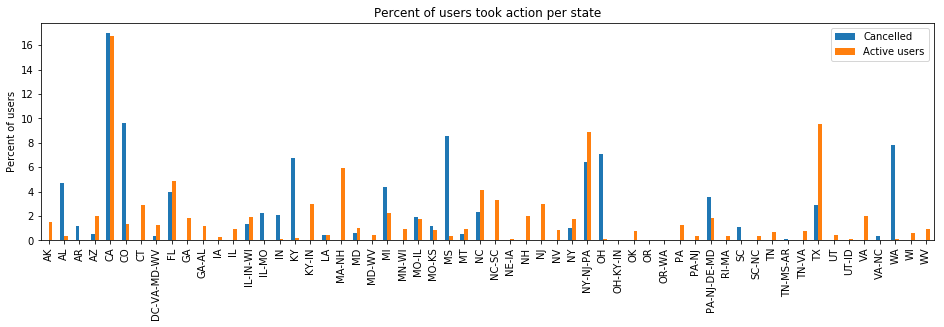

In [48]:
draw_plot('state', label_rotation=90);

In [49]:
dfp.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn,state
0,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,CT
1,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,CT
2,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,CT
3,None,Logged In,Darianna,F,3,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,Thumbs Up,1538016340000,31,None,307,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,CT
4,Josh Ritter,Logged In,Darianna,F,4,Carpenter,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Folk Bloodbath,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,CT


## Feature Engineering

In [50]:
churn_users = df.select('userId', 'churn').dropDuplicates()

In [51]:
print((df.count(), len(df.columns)))

(278154, 20)


In [52]:
def create_dummy_df (col, dictionary):
    col_df = df.select('userId', col).dropDuplicates().replace(dictionary, subset=col)
    col_df = col_df.select('userId', col_df[col].cast('int'))
    print(df.show(5))
    return col_df


gender_df = create_dummy_df('gender', {'M':'1', 'F':'0'})

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|state|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|    0|   CT|
|Francesca Battist...|Logged In| Darianna|     F|            1|C

In [53]:
level_df = create_dummy_df('level', {'paid':'1', 'free':'0'})

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|state|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|    0|   CT|
|Francesca Battist...|Logged In| Darianna|     F|            1|C

In [54]:
dfp.artist.unique().shape[0]

17656

In [55]:
song_length = df.filter(df.page=='NextSong').select('userId', 'sessionId', 'length')
song_length = song_length.withColumn('hours', (song_length.length / 3600))
song_length = song_length.groupBy('userId', 'sessionId').sum('hours')
song_length = song_length.groupBy('userId').agg(
                        sF.avg('sum(hours)').alias('mean_hours'), 
                        sF.stddev('sum(hours)').alias('stdev_hours')).na.fill(0)
song_length.toPandas().head(10)

,userId,mean_hours,stdev_hours
0,100010,2.656385,1.594089
1,200002,4.352263,3.481087
2,125,0.580309,0.000000
3,51,14.535440,11.600663
4,124,10.042779,9.370878
5,7,1.509289,1.737257
6,54,5.645595,6.724164
7,15,9.470389,6.159368
8,155,9.202745,6.528672
9,100014,3.134420,1.754365


In [56]:
# Distribution of pages
user_page_distribution = df.groupby('userId').pivot('page').count().na.fill(0) #.toPandas().head(30)
user_page_distribution = user_page_distribution.drop(*['Cancel','Cancellation Confirmation'])
pages_cols = user_page_distribution.columns[1:]
new_df = user_page_distribution.withColumn('total', sum(user_page_distribution[col] for col in pages_cols))
for col in pages_cols:
    new_df = new_df.withColumn(f'norm_{col}', new_df[col] / new_df['total'] * 100.)
new_df = new_df.drop('total')
new_df = new_df.drop(*pages_cols)
oldColumns = new_df.columns
newColumns = ['userId'] + pages_cols
user_page_distribution = reduce(lambda new_df, idx: new_df.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), new_df)
new_df=None
user_page_distribution.toPandas().head(10)

,userId,About,Add Friend,Add to Playlist,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,0.632911,0.843882,1.687764,1.054852,0.000000,0.421941,4.219409,1.054852,81.645570,1.476793,0.000000,0.632911,0.000000,0.210970,1.265823,4.430380,0.421941
1,100010,0.262467,1.049869,1.837270,0.000000,0.000000,0.524934,2.887139,1.312336,72.178478,13.648294,0.000000,0.000000,0.000000,0.000000,1.312336,4.461942,0.524934
2,125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,88.888889,11.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,51,0.081235,1.137287,2.112104,0.934200,0.040617,0.487409,3.046304,0.974817,85.743298,0.000000,0.040617,0.487409,0.000000,0.000000,0.852965,4.061738,0.000000
4,124,0.145078,1.533679,2.445596,0.849741,0.124352,0.476684,3.647668,1.222798,84.538860,0.082902,0.124352,0.414508,0.000000,0.000000,0.849741,3.544041,0.000000
5,7,0.000000,0.497512,2.487562,0.000000,0.497512,0.497512,4.975124,1.492537,74.626866,7.960199,0.497512,1.492537,0.000000,0.000000,0.497512,3.482587,0.995025
6,54,0.145560,0.960699,2.096070,1.135371,0.029112,0.494905,3.755459,1.048035,82.707424,1.368268,0.087336,0.494905,0.029112,0.029112,0.844250,4.745269,0.029112
7,15,0.087796,1.360843,2.589991,1.229148,0.087796,0.351185,4.082529,1.185250,84.021071,0.043898,0.087796,0.702371,0.000000,0.000000,0.614574,3.555751,0.000000
8,155,0.199601,1.097804,2.395210,1.197605,0.299401,0.898204,2.994012,1.397206,81.836327,0.798403,0.000000,0.499002,0.000000,0.099800,0.299401,5.788423,0.199601
9,132,0.173611,1.779514,1.649306,0.824653,0.130208,0.694444,3.602431,1.475694,83.680556,0.086806,0.173611,0.737847,0.000000,0.043403,0.737847,4.166667,0.043403


In [57]:
song_user_df = df.filter(df.page == 'NextSong').groupBy(
                        'userId', 'sessionId').count()
song_user_df = song_user_df.groupBy('userId').agg(
                        sF.avg('count').alias('mean_songs'), 
                        sF.stddev('count').alias('stdev_songs'))
song_user_df = song_user_df.na.fill(0)
song_user_df.show(3)

+------+------------------+------------------+
|userId|        mean_songs|       stdev_songs|
+------+------------------+------------------+
|100010|39.285714285714285| 22.96166577663945|
|200002|              64.5|51.309843110264914|
|   125|               8.0|               0.0|
+------+------------------+------------------+
only showing top 3 rows



In [58]:
artists_user_fans = df.select('userId', 'artist').dropDuplicates().groupBy('userId').count().withColumnRenamed("count", "num_aritst")
artists_user_fans.show(3)

+------+----------+
|userId|num_aritst|
+------+----------+
|100010|       253|
|200002|       340|
|   125|         9|
+------+----------+
only showing top 3 rows



In [59]:
session_end = df.groupBy('userId', 'sessionId').max('ts').withColumnRenamed(
                                                            'max(ts)', 'end')
session_start = df.groupBy('userId', 'sessionId').min('ts').withColumnRenamed(
                                                            'min(ts)', 'start')
session_df = session_start.join(session_end,['userId', 'sessionId'])
ticks_per_hours = 1000 * 60 * 60
session_df = session_df.select('userId', 'sessionId', ((
    session_df.end-session_df.start)/ticks_per_hours).alias('session_hours'))
session_df.show(3)

+------+---------+------------------+
|userId|sessionId|     session_hours|
+------+---------+------------------+
|   101|      635|55.000277777777775|
|   110|     1776|1.3908333333333334|
|   120|      627|15.855555555555556|
+------+---------+------------------+
only showing top 3 rows



In [60]:
session_user_df = session_df.groupBy('userId').agg(
                        sF.avg('session_hours').alias('mean_session_h'), 
                        sF.stddev('session_hours').alias('stdev_session_h'))
session_user_df = session_user_df.na.fill(0)
session_user_df.show(3)

+------+-------------------+------------------+
|userId|     mean_session_h|   stdev_session_h|
+------+-------------------+------------------+
|100010|  2.574722222222223|1.5888758093219746|
|200002|               4.44| 3.615756029749058|
|   125|0.49277777777777776|               0.0|
+------+-------------------+------------------+
only showing top 3 rows



In [61]:
num_sessions_user_df = df.select('userId', 'sessionId').dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'num_sessions')
num_sessions_user_df.show(3)

+------+------------+
|userId|num_sessions|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
+------+------------+
only showing top 3 rows



In [62]:
def days_since_subscription(df, col_name='days_on'):
    reg_ts = df.select('userId', 'registration').dropDuplicates().withColumnRenamed('registration', 'start')
    end_ts = df.groupBy('userId').max('ts').withColumnRenamed('max(ts)', 'end')
    reg_df = reg_ts.join(end_ts,'userId')
    ticks_per_day = 1000 * 60 * 60 * 24 # as the timestamp is in ticks (0.001 seconds)
    reg_df = reg_df.select('userId', ((reg_df.end-reg_df.start)/ticks_per_day).alias(col_name))
    return reg_df

reg_df = days_since_subscription(df, col_name='days_total_subscription')
reg_df.show(5)

+------+-----------------------+
|userId|days_total_subscription|
+------+-----------------------+
|100010|      55.64365740740741|
|200002|      70.07462962962963|
|   125|      71.31688657407408|
|   124|     131.55591435185184|
|    51|     19.455844907407407|
+------+-----------------------+
only showing top 5 rows



In [63]:
df_paid = df.filter(df.level=='paid')
paid_df = days_since_subscription(df_paid, col_name='days_paid_subscription')
paid_df.show(5)

+------+----------------------+
|userId|days_paid_subscription|
+------+----------------------+
|200002|     70.07462962962963|
|   124|    131.55591435185184|
|    51|    19.455844907407407|
|    15|    56.513576388888886|
|    54|    110.75168981481481|
+------+----------------------+
only showing top 5 rows



In [64]:
df_free = df.filter(df.level=='free')
free_df = days_since_subscription(df_free, col_name='days_free_subscription')
free_df.show(5)

+------+----------------------+
|userId|days_free_subscription|
+------+----------------------+
|100010|     55.64365740740741|
|200002|     41.49415509259259|
|   125|     71.31688657407408|
|     7|     72.77818287037037|
|    54|     96.45179398148149|
+------+----------------------+
only showing top 5 rows



In [65]:
df.filter(df.page=='NextSong').toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn,state
0,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,CT
1,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,CT
2,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,CT
3,Josh Ritter,Logged In,Darianna,F,4,Carpenter,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Folk Bloodbath,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,CT
4,LMFAO,Logged In,Darianna,F,5,Carpenter,183.74485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Yes,200,1539004511000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,CT
5,OneRepublic,Logged In,Darianna,F,6,Carpenter,224.67873,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Secrets,200,1539004694000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,CT
6,Dwight Yoakam,Logged In,Darianna,F,7,Carpenter,239.30730,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,You're The One,200,1539004918000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,CT
7,The Chordettes,Logged In,Darianna,F,9,Carpenter,142.41914,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Mr Sandman,200,1539005157000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,CT
8,Coko featuring Kirk Franklin,Logged In,Darianna,F,10,Carpenter,249.31220,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,I Get Joy,200,1539005299000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,CT
9,The Cure,Logged In,Darianna,F,11,Carpenter,52.27057,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,The Final Sound,200,1539005548000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,CT


In [66]:
paid_free_df = df.filter(df.page=='NextSong').groupBy('userId').pivot('level').count()
paid_free_df = paid_free_df.na.fill(0)
active_cols = paid_free_df.columns[1:]
paid_free_df = paid_free_df.withColumn('total', 
                                       sum(paid_free_df[col] for col in active_cols))
for col in active_cols:
    paid_free_df = paid_free_df.withColumn(f'{col}_percent', 
                                           paid_free_df[col] / paid_free_df.total * 100)
active_cols.append('total')    
paid_free_df = paid_free_df.drop(*active_cols)
paid_free_df.show(10)

+------+------------------+-----------------+
|userId|      free_percent|     paid_percent|
+------+------------------+-----------------+
|200002| 22.48062015503876|77.51937984496125|
|100010|             100.0|              0.0|
|   125|             100.0|              0.0|
|     7|             100.0|              0.0|
|   124|               0.0|            100.0|
|    51|               0.0|            100.0|
|    54|15.452305526223162|84.54769447377683|
|    15|               0.0|            100.0|
|   155|12.317073170731707| 87.6829268292683|
|   132|1.4522821576763485|98.54771784232366|
+------+------------------+-----------------+
only showing top 10 rows



In [67]:
paid_free_df = paid_free_df.drop('free_percent')
paid_free_df.show(3)

+------+-----------------+
|userId|     paid_percent|
+------+-----------------+
|200002|77.51937984496125|
|100010|              0.0|
|   125|              0.0|
+------+-----------------+
only showing top 3 rows



In [68]:
pickedFeatures = [gender_df, paid_free_df, song_length, 
                   user_page_distribution, song_user_df, artists_user_fans, 
                   session_user_df, num_sessions_user_df, reg_df]
pickedFeatures_names = ['gender_df', 'paid_free_df', 'song_length', 
                   'user_page_distribution', 'song_user_df', 'artists_user_fans', 
                   'session_user_df', 'num_sessions_user_df', 'reg_df']

In [69]:
final_df = churn_users
for i, feature in enumerate(pickedFeatures):
    df_to_join = feature#.withColumnRenamed('userId', 't_userId')
    final_df = final_df.join(df_to_join, 'userId', how='inner')#.drop('t_userId')#.show(10)
    final_df = final_df.dropDuplicates()
final_df = final_df.orderBy('userId', ascending=True)

In [70]:
final_df.write.mode("overwrite").csv("saved_user_dataset")

In [71]:
#final_df.write.format("saved_user_dataset.csv").option("header", "true").csv(
#        path = "s3://emrbucket5124/folder", mode = "overwrite"
#    )

In [72]:
final_dfp = final_df.toPandas()
final_dfp.head(10)

,userId,churn,gender,paid_percent,mean_hours,stdev_hours,About,Add Friend,Add to Playlist,Downgrade,...,Thumbs Down,Thumbs Up,Upgrade,mean_songs,stdev_songs,num_aritst,mean_session_h,stdev_session_h,num_sessions,days_total_subscription
0,10,0,1,100.000000,7.725295,8.985657,0.251572,1.509434,1.132075,0.880503,...,0.503145,4.654088,0.000000,112.166667,133.324291,566,7.662454,8.991061,6,51.762650
1,100,0,1,91.349739,5.497368,5.137933,0.373367,1.524580,1.897946,0.933416,...,0.840075,4.604854,0.031114,78.882353,74.057621,1706,5.275317,5.133618,35,64.873773
2,100001,1,0,0.000000,2.435677,1.055065,0.000000,1.081081,1.621622,0.000000,...,1.081081,4.324324,1.081081,33.250000,16.839933,126,2.469306,1.051126,4,44.800220
3,100002,0,0,100.000000,3.441661,5.918537,0.000000,0.458716,2.293578,0.917431,...,0.000000,2.293578,0.000000,48.750000,84.428964,185,3.353056,5.901765,4,160.472072
4,100003,1,0,0.000000,1.709225,2.265005,0.000000,0.000000,2.631579,0.000000,...,0.000000,3.947368,0.000000,25.500000,33.234019,51,1.651944,2.260385,2,22.748113
5,100004,0,0,48.301486,3.215005,3.808716,0.000000,1.526104,1.847390,0.803213,...,0.883534,2.811245,0.642570,47.100000,55.459706,734,3.099775,3.895202,21,172.440081
6,100005,1,1,0.000000,2.572022,0.907743,0.000000,1.401869,1.401869,0.000000,...,1.401869,3.271028,1.869159,38.500000,13.771952,150,2.003111,1.367039,5,85.195590
7,100006,1,0,0.000000,1.626359,0.000000,0.000000,9.523810,2.380952,0.000000,...,4.761905,4.761905,0.000000,26.000000,0.000000,27,1.557222,0.000000,1,9.127164
8,100007,1,0,100.000000,3.225164,3.782691,0.000000,3.281853,1.737452,1.351351,...,1.158301,3.667954,0.000000,47.000000,55.366958,358,3.156852,3.789902,9,115.387616
9,100008,0,0,93.393782,8.860963,12.599652,0.319149,1.808511,3.191489,1.063830,...,0.638298,3.936170,0.425532,128.666667,182.128160,624,8.804213,12.541217,6,68.228565


In [73]:
final_df

DataFrame[userId: string, churn: bigint, gender: int, paid_percent: double, mean_hours: double, stdev_hours: double, About: double, Add Friend: double, Add to Playlist: double, Downgrade: double, Error: double, Help: double, Home: double, Logout: double, NextSong: double, Roll Advert: double, Save Settings: double, Settings: double, Submit Downgrade: double, Submit Upgrade: double, Thumbs Down: double, Thumbs Up: double, Upgrade: double, mean_songs: double, stdev_songs: double, num_aritst: bigint, mean_session_h: double, stdev_session_h: double, num_sessions: bigint, days_total_subscription: double]

## Modeling

In [74]:
#final_df = spark.read.option("header","true").csv("s3://emrbucket5124/folder/")

In [75]:
final_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- paid_percent: double (nullable = true)
 |-- mean_hours: double (nullable = false)
 |-- stdev_hours: double (nullable = false)
 |-- About: double (nullable = true)
 |-- Add Friend: double (nullable = true)
 |-- Add to Playlist: double (nullable = true)
 |-- Downgrade: double (nullable = true)
 |-- Error: double (nullable = true)
 |-- Help: double (nullable = true)
 |-- Home: double (nullable = true)
 |-- Logout: double (nullable = true)
 |-- NextSong: double (nullable = true)
 |-- Roll Advert: double (nullable = true)
 |-- Save Settings: double (nullable = true)
 |-- Settings: double (nullable = true)
 |-- Submit Downgrade: double (nullable = true)
 |-- Submit Upgrade: double (nullable = true)
 |-- Thumbs Down: double (nullable = true)
 |-- Thumbs Up: double (nullable = true)
 |-- Upgrade: double (nullable = true)
 |-- mean_songs: double (nullable = false)
 |-- stdev

In [76]:
for col in final_df.columns:
    final_df = final_df.withColumnRenamed(col, col.replace(' ', '_').replace('.', ''))
print(final_df.columns)

['userId', 'churn', 'gender', 'paid_percent', 'mean_hours', 'stdev_hours', 'About', 'Add_Friend', 'Add_to_Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong', 'Roll_Advert', 'Save_Settings', 'Settings', 'Submit_Downgrade', 'Submit_Upgrade', 'Thumbs_Down', 'Thumbs_Up', 'Upgrade', 'mean_songs', 'stdev_songs', 'num_aritst', 'mean_session_h', 'stdev_session_h', 'num_sessions', 'days_total_subscription']


In [77]:
final_df = final_df.withColumn('userId', final_df.userId.cast(sT.IntegerType()))
for col in final_df.columns[1:12]:
    final_df = final_df.withColumn(col, final_df[col].cast(sT.IntegerType()))
for col in final_df.columns[12:]:
    final_df = final_df.withColumn(col, final_df[col].cast(sT.FloatType()))
final_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- paid_percent: integer (nullable = true)
 |-- mean_hours: integer (nullable = true)
 |-- stdev_hours: integer (nullable = true)
 |-- About: integer (nullable = true)
 |-- Add_Friend: integer (nullable = true)
 |-- Add_to_Playlist: integer (nullable = true)
 |-- Downgrade: integer (nullable = true)
 |-- Error: integer (nullable = true)
 |-- Help: integer (nullable = true)
 |-- Home: float (nullable = true)
 |-- Logout: float (nullable = true)
 |-- NextSong: float (nullable = true)
 |-- Roll_Advert: float (nullable = true)
 |-- Save_Settings: float (nullable = true)
 |-- Settings: float (nullable = true)
 |-- Submit_Downgrade: float (nullable = true)
 |-- Submit_Upgrade: float (nullable = true)
 |-- Thumbs_Down: float (nullable = true)
 |-- Thumbs_Up: float (nullable = true)
 |-- Upgrade: float (nullable = true)
 |-- mean_songs: float (nullable = false)
 |-- stdev_

In [78]:
final_df = final_df.na.fill(0)

In [79]:
features_labels = final_df.columns[2:]

In [80]:
features_vector = VectorAssembler(inputCols=final_df.columns[2:], outputCol='features')
input_data = features_vector.transform(final_df)

In [81]:
features_scaler = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='scaled_features')
features_scaler_fit = features_scaler.fit(input_data)
scaled_inputs = features_scaler_fit.transform(input_data)

In [82]:
ml_data = scaled_inputs.select(scaled_inputs.churn.alias('label'), scaled_inputs.scaled_features.alias('features'))

In [83]:
train, test = ml_data.randomSplit([0.80, 0.20], seed=179)

In [84]:
def get_classifier_metrics(trained_model, train_data, test_data):
    def get_specific_metrics(trained_model, data):
        res2 = trained_model.transform(data).select('label', 'prediction')
        TruePos = res2.filter((res2.prediction==1)& (res2.label == res2.prediction) ).count()
        TrueNeg = res2.filter((res2.prediction==0)& (res2.label == res2.prediction) ).count()
        FalsPos = res2.filter((res2.prediction==1)& (res2.label != res2.prediction) ).count()
        FalsNeg = res2.filter((res2.prediction==0)& (res2.label != res2.prediction) ).count()
        accuracy = res2.filter(res2.label == res2.prediction).count()/res2.count()
        precision = TruePos/(TruePos+FalsPos)
        recall = TruePos/(TruePos+FalsNeg)
        f1score = 2 * precision * recall / (precision + recall)
        return accuracy, precision, recall, f1score
    train_metrics = get_specific_metrics(trained_model, train_data)
    test_metrics = get_specific_metrics(trained_model, test_data)
    labels =['Train', 'Test']
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F-Score']
    metrics_data =np.array((train_metrics, test_metrics))
    return pd.DataFrame(data=metrics_data.T, columns=labels, index=metrics_names)

### GBT model

In [85]:
model = GBTClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth,[3, 5, 8]) \
    .addGrid(model.maxBins ,[8, 5]) \
    .addGrid(model.maxIter ,[8, 5]) \
    .build()

In [86]:
model_evaluator = CrossValidator(estimator=model, estimatorParamMaps=param_grid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=3, seed=100)

In [87]:
fitted_model = model_evaluator.fit(train)

In [88]:
display(get_classifier_metrics(fitted_model, train, test))

,Train,Test
Accuracy,0.934066,0.697674
Precision,1.000000,0.285714
Recall,0.714286,0.200000
F-Score,0.833333,0.235294


### Random Forest

In [89]:
model = RandomForestClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth,[5, 8]) \
    .addGrid(model.maxBins ,[8, 5]) \
    .addGrid(model.numTrees ,[15, 10]) \
    .build()

In [90]:
model_evaluator = CrossValidator(estimator=model, estimatorParamMaps=param_grid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=3, seed=100)

In [91]:
fitted_model = model_evaluator.fit(train)

In [92]:
display(get_classifier_metrics(fitted_model, train, test))

,Train,Test
Accuracy,0.989011,0.744186
Precision,1.000000,0.400000
Recall,0.952381,0.200000
F-Score,0.975610,0.266667
